In [44]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

In [46]:
token_path = "/content/gdrive/My Drive/Flickr8k/Flickr8k_text/Flickr8k.lemma.token.txt"
train_images_path = '/content/gdrive/My Drive/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '/content/gdrive/My Drive/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = '/content/gdrive/My Drive/Flickr8k/Flickr8k_images/'
glove_path = '/content/gdrive/My Drive/glove6b'

doc = open(token_path,'r').read()
print(doc[:410])

1305564994_00513f9a5b.jpg#0	A man in street racer armor be examine the tire of another racer 's motorbike .
1305564994_00513f9a5b.jpg#1	Two racer drive a white bike down a road .
1305564994_00513f9a5b.jpg#2	Two motorist be ride along on their vehicle that be oddly design and color .
1305564994_00513f9a5b.jpg#3	Two person be in a small race car drive by a green hill .
1305564994_00513f9a5b.jpg#4	Two person i


In [47]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [48]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

In [49]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 6751


In [50]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [51]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [52]:
doc = open(test_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

test = set(dataset)

In [11]:
test

{'3019842612_8501c1791e',
 '3437654963_c4fdc17e8b',
 '317488612_70ac35493b',
 '421322723_3470543368',
 '3490736665_38710f4b91',
 '3430607596_7e4f74e3ff',
 '127490019_7c5c08cb11',
 '1472230829_803818a383',
 '2666179615_f05a9d8331',
 '2662845514_8620aaee96',
 '2892995070_39f3c9a56e',
 '3725202807_12fbfdd207',
 '525863257_053333e612',
 '3670907052_c827593564',
 '1394368714_3bc7c19969',
 '354642192_3b7666a2dd',
 '2295750198_6d152d7ceb',
 '2510020918_b2ca0fb2aa',
 '1765164972_92dac06fa9',
 '3605061440_1d08c80a57',
 '2346401538_f5e8da66fc',
 '2918769188_565dd48060',
 '3128164023_ebe8da4c32',
 '3613800013_5a54968ab0',
 '3591458156_f1a9a33918',
 '56489627_e1de43de34',
 '270724499_107481c88f',
 '2100816230_ff866fb352',
 '3609032038_005c789f64',
 '3119076670_64b5340530',
 '2183227136_8bb657846b',
 '57422853_b5f6366081',
 '1262583859_653f1469a9',
 '2473791980_805c819bd4',
 '317383917_d8bfa350b6',
 '3385246141_a263d1053e',
 '3658427967_6e2e57458d',
 '3767841911_6678052eb6',
 '3015863181_92ff43f4d8

In [53]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

sub_image = ['/content/subjective/sample1.jpg','/content/subjective/sample2.jpg','/content/subjective/sample3.jpg','/content/subjective/sample4.jpg','/content/subjective/sample5.jpg']

In [55]:
sub_image

['/content/subjective/sample1.jpg',
 '/content/subjective/sample2.jpg',
 '/content/subjective/sample3.jpg',
 '/content/subjective/sample4.jpg',
 '/content/subjective/sample5.jpg']

In [56]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [57]:
test_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in test:
        if image_id not in test_descriptions:
            test_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        test_descriptions[image_id].append(desc)

In [ ]:
test_descriptions['1056338697_4f7d7ce270']

['startseq a blond woman in a blue shirt appear to wait for a ride endseq',
 'startseq a blond woman be on a street hail a taxi endseq',
 'startseq a woman be signal be to traffic as see from behind endseq',
 'startseq a woman with blond hair wear a blue tube top be wave on the side of a street endseq',
 'startseq a woman in a blue dress be hold out her arm at oncoming traffic endseq']

In [58]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [59]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1350


In [60]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [61]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [62]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [63]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [64]:
model = InceptionV3(weights='imagenet')

In [65]:
model_new = Model(model.input, model.layers[-2].output)

In [66]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [67]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

#encoding_train = {}
#for img in train_img:
 #   encoding_train[img[len(images_path):]] = encode(img)
#train_features = encoding_train

#encoding_test = {}
#for img in test_img:
 #   encoding_test[img[len(images_path):]] = encode(img)  loaded instead in the next cell
encoding_sub = {}
for img in sub_image:
  im_path = '/content/subjective'
  encoding_sub[img[len(im_path):]] = encode(img)





In [68]:
encoding_train = {}
encoding_test = {}


import pickle #credits to stack overflow user= blender

with open('/content/gdrive/My Drive/train_encoding.pkl', 'rb') as handle:
    encoding_train = pickle.load(handle)

with open('/content/gdrive/My Drive/test_encoding.pkl', 'rb') as handle:
    encoding_test = pickle.load(handle)

In [69]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 38, 200)      270200      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [70]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [71]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [72]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [73]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

#generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
#model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

model.load_weights('/content/gdrive/My Drive/mymodel.h5')

In [ ]:
#model.save_weights('/content/mymodel.h5')

In [74]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [75]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [78]:
encoding_sub

{'/sample1.jpg': array([0.10363436, 0.6592405 , 0.04707847, ..., 0.5162358 , 0.5699519 ,
        0.12665501], dtype=float32),
 '/sample2.jpg': array([0.12832971, 0.6262431 , 0.45737064, ..., 0.21069905, 0.9840437 ,
        0.6636263 ], dtype=float32),
 '/sample3.jpg': array([0.65734124, 0.55411136, 0.53661495, ..., 0.83809584, 1.144691  ,
        0.22205427], dtype=float32),
 '/sample4.jpg': array([0.31902552, 0.438075  , 0.56303823, ..., 0.33003932, 0.3395024 ,
        0.22604957], dtype=float32),
 '/sample5.jpg': array([0.20755634, 0.25863442, 0.08564568, ..., 0.6909558 , 0.54197776,
        0.4773209 ], dtype=float32)}

In [ ]:

from nltk.translate.bleu_score import sentence_bleu
bl = 0
i = 0
for p in test:
  i = i+1
  image = p+'.jpg'
  image = encoding_test[pic].reshape((1,2048))
  r = test_descriptions[p]
  d = beam_search_predictions(image, beam_index = 5)
  score = sentence_bleu(r, d)
  bl = bl+score
  print(i , score)


bleu = bl/1000
print(' .BLEU SCORE IS'+bleu)

1 0.3392466320187733
2 0.2339559654987272
3 0.4464736763815645
4 0.29644060859029625
5 0.458551832477267
6 0.35026586424142897
7 0.3333551114368803
8 0.44830457894510195
9 0.24103033993764666
10 0.38967188124490904
11 0.4662596184043319
12 0.37244265186746417
13 0.5680937319211965
14 0.3636009128170907
15 0.42714192349073626
16 0.3975433723902369
17 0.41344247583465316
18 0.5667475735687274
19 0.41128204129540774
20 0.30208178754032794
21 0.290454877142018
22 0.37125867749522784
23 0.3651868600533932
24 0.40073940440097294
25 0.4705169693249273
26 0.40073940440097294
27 0.3367686117006247
28 0.4474547275088797
29 0.4507722569666049
30 0.23441070156873517
31 0.5340707541067164
32 0.31429854049457934
33 0.33570066118680175
34 0.4245752604201615
35 0.31183862439611776
36 0.4831579797787826
37 0.28855951247020356
38 0.2388488455322318
39 0.6105927210738389
40 0.39905595909600494
41 0.516804602031691
42 0.35529166545919316
43 0.24677721152898274
44 0.4310898211921693
45 0.2914437500046104
4

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


48 0.4552783719555951
49 0.27037392269181837
50 0.38031514846815473
51 0.3954163183928007
52 0.21405006054790263
53 0.3433836228575441
54 0.3937106726632864
55 0.4326894851675108
56 0.4354920364712097
57 0.43222834412134986
58 0.2866349951853739
59 0.6858574656324453
60 0.3963106649242097
61 0.49932797104420695
62 0.32033983308646685
63 0.28470549576769794
64 0.3261479109119879
65 0.2615084735265379
66 0.31359553122785805
67 0.27121819351981374
68 0.45901094012967086
69 0.340345060427419
70 0.337467406184446
71 0.29042767355630905
72 0.5908554319114901
73 0.4094104504545343
74 0.31187713487840746
75 0.36412156955207203
76 0.23961661128439754
77 0.5548510142312797
78 0.2372131540377057
79 0.36864873387190306
80 0.5218587584286369
81 0.38622720847749475
82 0.3948995457988185
83 0.40064795604436626
84 0.3534279503072224
85 0.3596089896444862
86 0.39797704586302163
87 0.47762504509160475
88 0.36783090158341647
89 0.24890219296590554
90 0.2697929162773373
91 0.7701243977797754
92 0.29023313

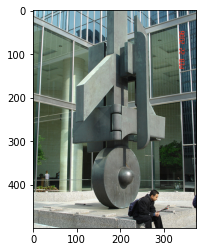

a boy in a red shirt be jump off a rock into a lake
Beam Search with K = 2: a boy in a red shirt be jump off a rock into a lake
Beam Search with K = 3: a boy in a red shirt be jump on a bed
Beam Search with K = 5: a little boy in a white shirt and blue jean be climb a rock wall


In [86]:
pic = '/sample1.jpg'
image = encoding_sub[pic].reshape((1,2048))
x=plt.imread('/content/subjective'+pic)
plt.imshow(x)
plt.show()

print(greedySearch(image))
print("Beam Search with K = 2:",beam_search_predictions(image, beam_index = 2))
print("Beam Search with K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search with K = 5:",beam_search_predictions(image, beam_index = 5))


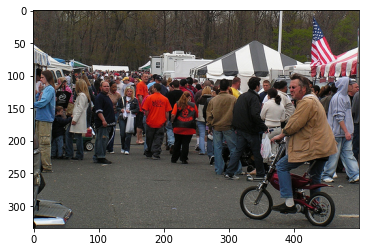

a group of person be stand in a street
Beam Search with K = 2: a group of child be play soccer in front of a building
Beam Search with K = 3: a group of person walk down a street
Beam Search with K = 5: a group of person walk down a street


In [87]:
pic = '/sample2.jpg'
image = encoding_sub[pic].reshape((1,2048))
x=plt.imread('/content/subjective'+pic)
plt.imshow(x)
plt.show()

print(greedySearch(image))
print("Beam Search with K = 2:",beam_search_predictions(image, beam_index = 2))
print("Beam Search with K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search with K = 5:",beam_search_predictions(image, beam_index = 5))


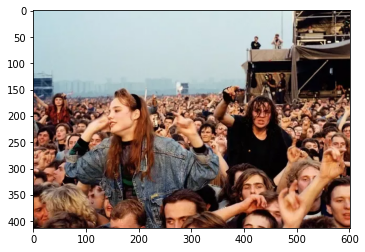

child be sit on a bench in a crowded
Beam Search with K = 2: many child be sit on a bench in front of a wooden hut
Beam Search with K = 3: a group of child sit on a bench in a crowd
Beam Search with K = 5: a group of child play in a water fountain


In [88]:
pic = '/sample3.jpg'
image = encoding_sub[pic].reshape((1,2048))
x=plt.imread('/content/subjective'+pic)
plt.imshow(x)
plt.show()

print(greedySearch(image))
print("Beam Search with K = 2:",beam_search_predictions(image, beam_index = 2))
print("Beam Search with K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search with K = 5:",beam_search_predictions(image, beam_index = 5))


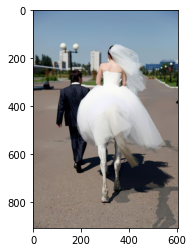

a little girl in a white dress be run along a dirt road
Beam Search with K = 2: a little girl in a pink tutu jump on a trampoline
Beam Search with K = 3: a little girl in a white bathe suit dance in front of a kiddie pool
Beam Search with K = 5: a little girl in a white bathe suit dance in front of a pool


In [89]:
pic = '/sample4.jpg'
image = encoding_sub[pic].reshape((1,2048))
x=plt.imread('/content/subjective'+pic)
plt.imshow(x)
plt.show()

print(greedySearch(image))
print("Beam Search with K = 2:",beam_search_predictions(image, beam_index = 2))
print("Beam Search with K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search with K = 5:",beam_search_predictions(image, beam_index = 5))


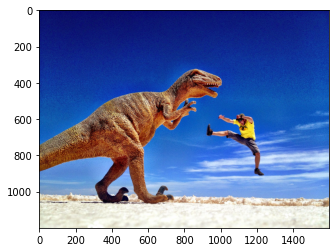

a little girl in a pink tutu be climb a rock wall
Beam Search with K = 2: a little girl in a white dress be blow bubble in a wooded area
Beam Search with K = 3: a little girl in an orange swimsuit be climb a rock wall
Beam Search with K = 5: a little girl in a yellow dress be climb a rock wall


In [90]:
pic = '/sample5.jpg'
image = encoding_sub[pic].reshape((1,2048))
x=plt.imread('/content/subjective'+pic)
plt.imshow(x)
plt.show()

print(greedySearch(image))
print("Beam Search with K = 2:",beam_search_predictions(image, beam_index = 2))
print("Beam Search with K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search with K = 5:",beam_search_predictions(image, beam_index = 5))
